In [1]:
from ect import sidelobe, spacenorm, freqnorm, fect, ifect
from ect.optimization import SingleImageGenerator, UnimodalGenerator, MultimodalGenerator
from ect import norm_minmax, complex_to_hsv
from ect import AntialiasParameters, Config

from ect.transforms.utils_new import fold_logpolar, unfold_logpolar
from ect.helpers import Mode

import cv2
import numpy as np
import matplotlib.pyplot as plt

### Sample image generation

In [2]:
def square_grid(
    dsize: tuple[int, int], 
    step: int, 
    thickness: int = 1
) -> np.ndarray:
    '''
    Generates square grid of size [dsize]
    with parametrized step.

    Outputs grid as grayscale image.
    '''
    out: np.ndarray = np.ones(dsize, dtype=float)

    # x grid
    for x in range(0, dsize[1]+1, step):
        # ic(x)
        out = cv2.line(out, (x, 0), (x, dsize[0]), (0), thickness)
    
    # y grid
    for y in range(0, dsize[0]+1, step):
        # ic(y)
        out = cv2.line(out, (0, y), (dsize[1], y), (0), thickness)
    
    return out

def sine_grid(
    dsize: tuple[int, int], 
    period: int, 
    angle_deg: int
):
    phi = angle_deg*np.pi/180

    x = np.linspace(0, dsize[1], dsize[1], endpoint=False)
    y = np.linspace(0, dsize[0], dsize[0], endpoint=False)

    xx, yy = np.meshgrid(x, y)

    return 1 + np.sin(2*np.pi/period*(xx*np.cos(phi)+ yy*np.sin(phi)))



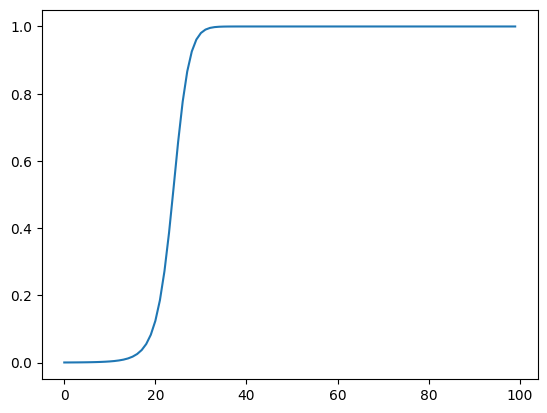

In [3]:
cfg = Config(offset_value_px=3)
dsize = (314, 100)
f = sidelobe(dsize, cfg)

# plt.imshow(f)
plt.plot(f[78, :])

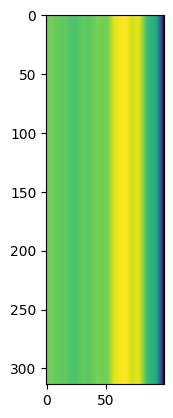

In [4]:
cfg = Config(offset_value_px=3)
dsize = (314, 100)
f = spacenorm(dsize, cfg)

plt.imshow(f)

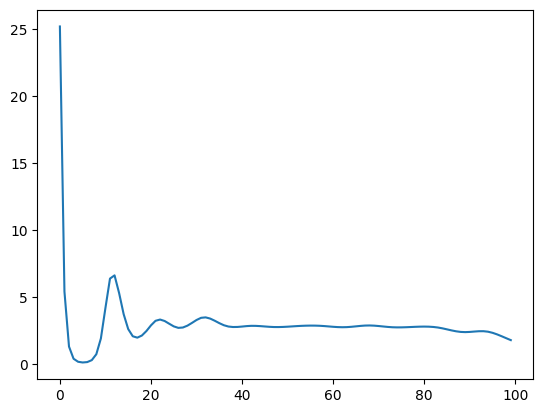

In [5]:
cfg = Config(offset_value_px=3)
dsize = (314, 100)
f = freqnorm(dsize, cfg)

# plt.imshow(f)
plt.plot(f[78, :])

### ECT testing

2024-04-30 07:24:06.702 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=10
2024-04-30 07:24:06.703 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping


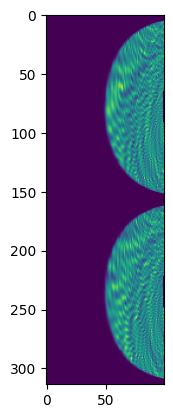

In [7]:
# IMNAME = "/home/mateusz/Desktop/Magisterka/library_tests/sample_images/sine.jpg"

# SIZE = 500

# srcimg = sine_grid((SIZE, SIZE), SIZE//20, 0)
# srcimg = norm_minmax(srcimg, 0, 255)

# plt.imshow(srcimg)
# cv2.imwrite(IMNAME, srcimg)


# gen = SingleImageGenerator(IMNAME, offset=5)

# mode = Mode(20, 60)
# modes = [Mode(25, 0), Mode(25, 90)]
modes = [Mode(100/x, 9*x, 1) for x in range(1, 20)]
# modes = [Mode(100/x, 0, 1/x) for x in range(1, 4, 2)]

# gen = UnimodalGenerator(mode, offset=5)
gen = MultimodalGenerator(modes, offset=10)

plt.imshow(gen.generate())

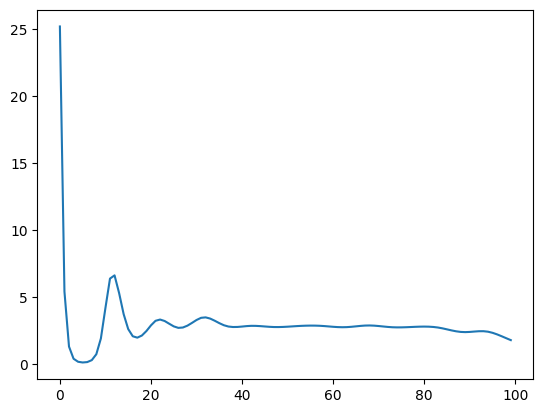

In [15]:
img = gen.generate()
P, R = img.shape
img = img[:P//2, :]

ect_cfg = Config(
    mode = "offset",
    offset_value_px = 10,
    ect_offset_value_px = 10,
    antialias = True,
)


# aa_params = [
#     AntialiasParameters(
#         factor = .45, # to optimize
#         slope = 0.25,
#         threshold = np.log(R)
#     ),   
#     AntialiasParameters(
#         factor = .25, # to optimize
#         slope = 0.25,
#         threshold = np.pi
#     )
# ]

# # ect_cfg.antialias_params = aa_params
# ect_cfg.antialias_factors = (0.35, 0.1)
# ect_cfg.freqnorm_knots = [0.5, 0.3, 0, 0, 0.3, 0.5, 0.3, 0.3]
# ect_cfg.spacenorm_knots = [0.8, 1, 0.8, 0.5, 0.3]


ect = fect(img, ect_cfg)
ffilt = freqnorm(ect.shape, ect_cfg)
ect *= ffilt

plt.plot(ffilt[78, :])
# plt.plot(ect_cfg.freqnorm_knots)

# ect[:, 200:] = 0
inv = ifect(ect, ect_cfg)
sfilt = spacenorm(inv.shape, ect_cfg)
# inv *= sfilt

inv = np.real(inv)

# plt.plot(sfilt[78, :])
# inv = cv2.normalize(inv, None, 0, 1, norm_type=cv2.NORM_MINMAX)

ic| snr(inorm, invnorm): -11.384889427184701


-11.384889427184701

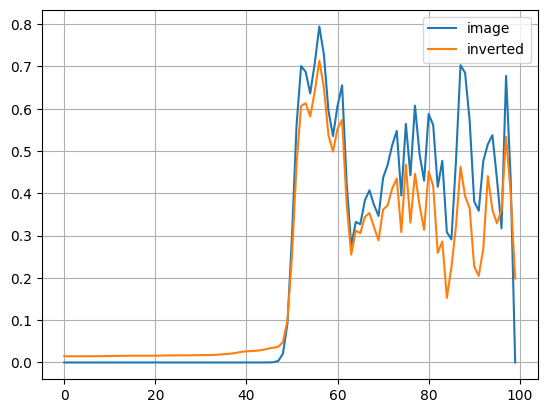

In [16]:
# filt = sidelobe(img.shape, Config(offset_value_px=5))
# inv -= inv.min().min() 
# inv *= filt

inorm = cv2.normalize(img, None, 1, 0, cv2.NORM_MINMAX)
invnorm = cv2.normalize(np.real(inv), None, 1, 0, cv2.NORM_MINMAX)

plt.plot(inorm[78, :])
plt.plot(invnorm[78, :])
plt.legend(["image", "inverted"])
plt.grid()

from ect.optimization import snr
from icecream import ic
ic(snr(inorm, invnorm))

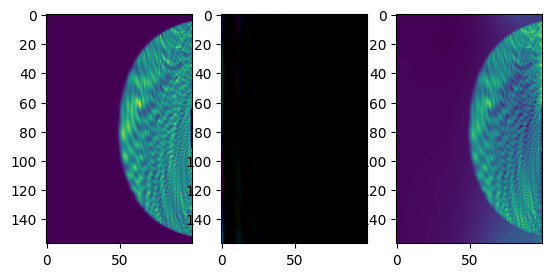

In [17]:
plt.subplot(1, 3, 1)
# logimg = gray2rgb(logimg)
plt.imshow(img)

plt.subplot(1, 3, 2)
# ect = unfold_logpolar(ect)
ect = complex_to_hsv(ect)
plt.imshow(ect)

plt.subplot(1, 3, 3)
# inv = gray2rgb(inv/255)

# inv = norm_minmax(inv, 0, 255)
plt.imshow(inv)


2024-04-30 07:26:29.737 | DEBUG    | ect.maps.ilogpolar_new:ilogpolar:78 - Running logpolar transform in offset mode
2024-04-30 07:26:29.745 | DEBUG    | ect.maps.ilogpolar_new:ilogpolar:94 - Applying bilinear pixel mapping
2024-04-30 07:26:29.773 | DEBUG    | ect.maps.ilogpolar_new:ilogpolar:78 - Running logpolar transform in offset mode
2024-04-30 07:26:29.781 | DEBUG    | ect.maps.ilogpolar_new:ilogpolar:94 - Applying bilinear pixel mapping


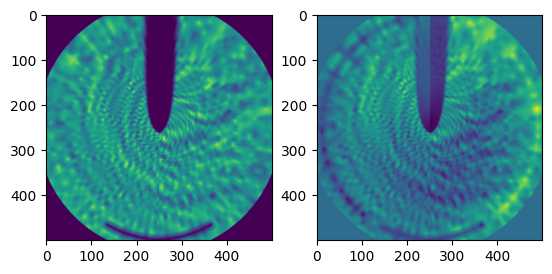

In [18]:
from ect import ilogpolar_new as ilogpolar

orig = ilogpolar(img, dsize=(500,500), radius=250, cfg=ect_cfg)
inv_ = ilogpolar(inv, dsize=(500,500), radius=250, cfg=ect_cfg)


plt.subplot(1, 2, 1)
plt.imshow(orig)

plt.subplot(1, 2, 2)
plt.imshow(inv_)